# Imports and Utility Variables

In [1]:
import os
import datetime

import numpy as np
import pandas as pd

import astropy.units as u
from astropy.timeseries import TimeSeries
from astropy.table import Table
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation

import matplotlib.pyplot as plt
import scienceplots
plt.style.use("science")

ITURBIDE_DATA_FILE_PATH = "/home/ramon/uanl/thesis/Backup Data/Iturbide/ATOJ339.9469+45.1464_SPM.dat"
GAIA_EPOCH_PHOTOMETRY_CSV_PATH = "/home/ramon/uanl/thesis/Backup Data/Gaia Epoch Photometry - Indiv/DR3/rel-norm-flux.ecsv"
ZTF_G_DATA_PATH = "/home/ramon/uanl/thesis/Backup Data/IRSA/rel-zg-flux.ecsv"
ZTF_R_DATA_PATH = "/home/ramon/uanl/thesis/Backup Data/IRSA/rel-zr-flux.ecsv"

ITURBIDE_OUTPUT_PATH = "/home/ramon/uanl/thesis/Backup Data/Iturbide/normalized_flux.ecsv"

In [2]:
objCoord = SkyCoord.from_name("ATO J339.9469+45.1464")
objCoord

<SkyCoord (ICRS): (ra, dec) in deg
    (339.94690379, 45.14639753)>

In [3]:
iturbideLocation = EarthLocation(lon=-99.895328*u.deg, lat=24.75521 * u.deg, height=2400*u.m)
iturbideLocation

<EarthLocation (-996310.5451336, -5711351.68420869, 2655479.91503921) m>

In [4]:
ztfPalomarLocation = EarthLocation.of_site("Palomar")
ztfPalomarLocation

<EarthLocation (-2410346.78217658, -4758666.82504051, 3487942.97502457) m>

# Load Data

## Iturbide

In [5]:
allIturbideObjDf = Table.read(ITURBIDE_DATA_FILE_PATH, format='ascii').to_pandas()
allIturbideObjDf.columns = ['fname', 'filter', 'exptime', 'hjd', 'airmass', 
					  'mag1', 'mag2', 'mag3', 'mag4', 'mag5', 'mag6', 'mag7', 
					  'err1', 'err2', 'err3', 'err4', 'err5', 'err6', 'err7']
allIturbideObjDf = allIturbideObjDf[(allIturbideObjDf['err1'] < 1) & (allIturbideObjDf['err5'] < 90)] # removing most egregious data points
allIturbideObjDf

,fname,filter,exptime,hjd,airmass,mag1,mag2,mag3,mag4,mag5,mag6,mag7,err1,err2,err3,err4,err5,err6,err7
0,s_0001o.fit,W,60.0,2.459875e+06,1.076,19.5253,16.7627,18.4668,17.8910,18.3033,18.3373,17.7953,0.019,0.003,0.009,0.006,0.008,0.008,0.006
1,s_0002o.fit,W,60.0,2.459875e+06,1.077,19.4874,16.7586,18.4767,17.8835,18.2984,18.3346,17.7884,0.016,0.003,0.008,0.006,0.007,0.007,0.005
2,s_0003o.fit,W,60.0,2.459875e+06,1.077,19.5269,16.7615,18.4741,17.8885,18.2952,18.3356,17.7870,0.015,0.003,0.008,0.006,0.007,0.007,0.005
3,s_0004o.fit,W,60.0,2.459875e+06,1.078,19.4836,16.7533,18.4543,17.8807,18.3064,18.3241,17.7936,0.016,0.003,0.008,0.006,0.007,0.007,0.006
4,s_0005o.fit,W,60.0,2.459875e+06,1.078,19.4708,16.7678,18.4633,17.8942,18.3105,18.3356,17.8094,0.015,0.003,0.008,0.006,0.007,0.007,0.006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1267,s_1268o.fit,W,60.0,2.459925e+06,1.310,19.8010,16.8106,18.5280,17.9386,18.3342,18.4044,17.8468,0.020,0.003,0.009,0.006,0.008,0.008,0.006
1268,s_1269o.fit,W,60.0,2.459925e+06,1.313,19.7907,16.8007,18.5086,17.9294,18.3472,18.3877,17.8116,0.021,0.003,0.009,0.006,0.008,0.008,0.006
1269,s_1270o.fit,W,60.0,2.459925e+06,1.316,19.8209,16.7875,18.5010,17.9217,18.3390,18.3683,17.8051,0.026,0.003,0.009,0.006,0.008,0.008,0.006
1270,s_1271o.fit,W,60.0,2.459925e+06,1.320,19.8697,16.8008,18.5043,17.9267,18.3425,18.3677,17.8264,0.023,0.003,0.009,0.006,0.008,0.008,0.006


In [6]:
COMP_ID = 5
atoDiffMag = pd.DataFrame(columns=['hjd', 'mag', 'err', 'filter'])
atoDiffMag['hjd'] = allIturbideObjDf['hjd']
atoDiffMag['mag'] = allIturbideObjDf['mag1'] - allIturbideObjDf[f'mag{COMP_ID}']
atoDiffMag['err'] = np.sqrt(np.power(allIturbideObjDf['err1'], 2) + np.power(allIturbideObjDf[f'err{COMP_ID}'], 2))
atoDiffMag['filter'] = 'Iturbide:Luminance'
atoDiffMag

,hjd,mag,err,filter
0,2.459875e+06,1.2220,0.020616,Iturbide:Luminance
1,2.459875e+06,1.1890,0.017464,Iturbide:Luminance
2,2.459875e+06,1.2317,0.016553,Iturbide:Luminance
3,2.459875e+06,1.1772,0.017464,Iturbide:Luminance
4,2.459875e+06,1.1603,0.016553,Iturbide:Luminance
...,...,...,...,...
1267,2.459925e+06,1.4668,0.021541,Iturbide:Luminance
1268,2.459925e+06,1.4435,0.022472,Iturbide:Luminance
1269,2.459925e+06,1.4819,0.027203,Iturbide:Luminance
1270,2.459925e+06,1.5272,0.024352,Iturbide:Luminance


In [7]:
# convert hjd -> bjd
iturbideHjdTime = Time(atoDiffMag['hjd'], scale='utc', format='jd')
heliocentricCorrection = iturbideHjdTime.light_travel_time(skycoord=objCoord, kind='heliocentric', location=iturbideLocation)
barycentricCorrection = iturbideHjdTime.light_travel_time(skycoord=objCoord, kind='barycentric', location=iturbideLocation)

iturbideBjdTime = (iturbideHjdTime - heliocentricCorrection) + barycentricCorrection

# using TCB scale to be compatible with Gaia
atoDiffMag['bjd'] = iturbideBjdTime.tcb.value
atoDiffMag

,hjd,mag,err,filter,bjd
0,2.459875e+06,1.2220,0.020616,Iturbide:Luminance,2.459875e+06
1,2.459875e+06,1.1890,0.017464,Iturbide:Luminance,2.459875e+06
2,2.459875e+06,1.2317,0.016553,Iturbide:Luminance,2.459875e+06
3,2.459875e+06,1.1772,0.017464,Iturbide:Luminance,2.459875e+06
4,2.459875e+06,1.1603,0.016553,Iturbide:Luminance,2.459875e+06
...,...,...,...,...,...
1267,2.459925e+06,1.4668,0.021541,Iturbide:Luminance,2.459925e+06
1268,2.459925e+06,1.4435,0.022472,Iturbide:Luminance,2.459925e+06
1269,2.459925e+06,1.4819,0.027203,Iturbide:Luminance,2.459925e+06
1270,2.459925e+06,1.5272,0.024352,Iturbide:Luminance,2.459925e+06


In [8]:
def hjd_to_observation_date(hjd: float) -> str:
    t = Time(hjd, format='jd', scale='utc')
    return t.strftime(r"%Y-%m-%d")
atoDiffMag['obsv_date'] = atoDiffMag['hjd'].apply(hjd_to_observation_date)
atoDiffMag

,hjd,mag,err,filter,bjd,obsv_date
0,2.459875e+06,1.2220,0.020616,Iturbide:Luminance,2.459875e+06,2022-10-22
1,2.459875e+06,1.1890,0.017464,Iturbide:Luminance,2.459875e+06,2022-10-22
2,2.459875e+06,1.2317,0.016553,Iturbide:Luminance,2.459875e+06,2022-10-22
3,2.459875e+06,1.1772,0.017464,Iturbide:Luminance,2.459875e+06,2022-10-22
4,2.459875e+06,1.1603,0.016553,Iturbide:Luminance,2.459875e+06,2022-10-22
...,...,...,...,...,...,...
1267,2.459925e+06,1.4668,0.021541,Iturbide:Luminance,2.459925e+06,2022-12-11
1268,2.459925e+06,1.4435,0.022472,Iturbide:Luminance,2.459925e+06,2022-12-11
1269,2.459925e+06,1.4819,0.027203,Iturbide:Luminance,2.459925e+06,2022-12-11
1270,2.459925e+06,1.5272,0.024352,Iturbide:Luminance,2.459925e+06,2022-12-11


## Gaia

In [9]:
gaiaDataDf = Table.read(GAIA_EPOCH_PHOTOMETRY_CSV_PATH).to_pandas()
gaiaDataDf['filter'] = gaiaDataDf['band'].map(lambda p: f"Gaia:{p}")
gaiaDataDf['bjd'] = gaiaDataDf['time'].map(lambda t: t + 2455197.5) # tcb, barycentric
gaiaDataDf.index += atoDiffMag.index[-1] + 1
gaiaDataDf

,source_id,transit_id,band,time,mag,flux,flux_error,flux_over_error,rejected_by_photometry,rejected_by_variability,other_flags,solution_id,norm_flux,norm_ferr,filter,bjd
1272,1982536257931470464,15914106402149388,G,1684.645069,16.809998,3555.883734,13.240487,268.561401,False,False,1,375316653866487564,1.657540,0.006172,Gaia:G,2.456882e+06
1273,1982536257931470464,15923847240881531,G,1684.821236,16.808627,3560.378122,11.872833,299.876038,False,False,1,375316653866487564,1.659635,0.005534,Gaia:G,2.456882e+06
1274,1982536257931470464,15927939542726427,G,1684.895246,16.925122,3198.144064,14.858678,215.237457,False,False,1,375316653866487564,1.490783,0.006926,Gaia:G,2.456882e+06
1275,1982536257931470464,15937680367558820,G,1685.071412,16.899170,3275.507705,64.642659,50.670994,False,False,4097,375316653866487564,1.526845,0.030133,Gaia:G,2.456883e+06
1276,1982536257931470464,15941772663767622,G,1685.145395,16.775474,3670.768815,13.205851,277.965332,False,False,4194305,375316653866487564,1.711092,0.006156,Gaia:G,2.456883e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1464,1982536257931470464,68564649765818840,RP,2636.797157,16.107843,2857.728742,34.570173,82.664581,False,False,0,375316653866487564,3.164652,0.038283,Gaia:RP,2.457834e+06
1465,1982536257931470464,68574390600082284,RP,2636.973312,16.210664,2599.517311,29.385957,88.461212,False,False,0,375316653866487564,2.878709,0.032542,Gaia:RP,2.457834e+06
1466,1982536257931470464,68578482921453413,RP,2637.047319,16.354475,2277.026942,38.569154,59.037514,False,False,0,375316653866487564,2.521582,0.042712,Gaia:RP,2.457835e+06
1467,1982536257931470464,71504440274863554,RP,2689.962995,16.131512,2796.104174,30.633779,91.275200,False,False,0,375316653866487564,3.096409,0.033924,Gaia:RP,2.457887e+06


## ZTF

In [10]:
ztfDataDf = pd.concat([Table.read(ZTF_G_DATA_PATH).to_pandas(), Table.read(ZTF_R_DATA_PATH).to_pandas()])
ztfDataDf['band'] = ztfDataDf['filtercode'].map(lambda f: 'ZTF:g' if f == 'zg' else 'ZTF:r')
ztfDataDf.rename(columns={'magerr': 'err'}, inplace=True)

# light travel time correction
ztfHjdTime = Time(ztfDataDf['hjd'], scale='utc', format='jd')
heliocentricCorrection = ztfHjdTime.light_travel_time(skycoord=objCoord, kind='heliocentric', location=ztfPalomarLocation)
barycentricCorrection = ztfHjdTime.light_travel_time(skycoord=objCoord, kind='barycentric', location=ztfPalomarLocation)

ztfBjdTime = (ztfHjdTime - heliocentricCorrection) + barycentricCorrection
ztfDataDf['bjd'] = ztfBjdTime.tcb.jd

ztfDataDf.index += gaiaDataDf.index[-1] + 1
ztfDataDf

,oid,expid,hjd,mjd,mag,err,catflags,filtercode,ra,dec,...,magzprms,clrcoeff,clrcounc,exptime,airmass,programid,flux,fluxerr,band,bjd
1469,771103200012081,47448814,2.458229e+06,58228.488148,17.584045,0.019734,0,zg,339.946963,45.146416,...,0.021569,-0.029770,0.000011,30.0,1.802,1,0.851247,0.015472,ZTF:g,2.458229e+06
1470,771103200012081,48044724,2.458235e+06,58234.447245,17.433418,0.018556,0,zg,339.946941,45.146397,...,0.028215,-0.034409,0.000019,30.0,2.126,1,0.977927,0.016713,ZTF:g,2.458235e+06
1471,771103200012081,48050421,2.458235e+06,58234.504213,17.494032,0.019011,0,zg,339.946911,45.146420,...,0.019131,-0.041266,0.000009,30.0,1.512,1,0.924828,0.016193,ZTF:g,2.458235e+06
1472,771103200012081,49846564,2.458253e+06,58252.465648,17.589140,0.019777,0,zg,339.946922,45.146425,...,0.015484,-0.081382,0.000006,30.0,1.441,1,0.847262,0.015433,ZTF:g,2.458253e+06
1473,771103200012081,50142988,2.458256e+06,58255.429884,17.303104,0.017659,0,zg,339.946927,45.146421,...,0.014942,-0.059330,0.000005,30.0,1.649,1,1.102635,0.017934,ZTF:g,2.458256e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2678,771203200016558,236545300,2.460120e+06,60119.453009,17.045118,0.015989,0,zr,339.946945,45.146414,...,0.010556,0.077099,0.000003,30.0,1.087,1,1.398383,0.020593,ZTF:r,2.460120e+06
2679,771203200016558,236744946,2.460122e+06,60121.449468,17.073063,0.016162,0,zr,339.946949,45.146407,...,0.010572,0.072927,0.000003,30.0,1.084,1,1.362851,0.020287,ZTF:r,2.460122e+06
2680,771203200016558,236945396,2.460124e+06,60123.453970,17.057766,0.016067,0,zr,339.946943,45.146413,...,0.011589,0.071636,0.000003,30.0,1.069,1,1.382188,0.020454,ZTF:r,2.460124e+06
2681,771203200016558,237144525,2.460126e+06,60125.445255,17.049385,0.016015,0,zr,339.946942,45.146416,...,0.011202,0.069426,0.000003,30.0,1.073,1,1.392899,0.020546,ZTF:r,2.460126e+06


## All data

In [11]:
allDataDf = pd.DataFrame()
allDataDf['bjd'] = pd.concat([atoDiffMag['bjd'], gaiaDataDf['bjd'], ztfDataDf['bjd']])
allDataDf['band'] = pd.concat([atoDiffMag['filter'], gaiaDataDf['filter'], ztfDataDf['band']])

allDataDf['iturbide_mag'] = atoDiffMag['mag']
allDataDf['iturbide_err'] = atoDiffMag['err']
allDataDf['obsv_date'] = atoDiffMag['obsv_date']

gaiaBands = {
    'Gaia:G': 'g',
    'Gaia:RP': 'r',
    'Gaia:BP': 'b'
}

for band, code in gaiaBands.items():
    bandData = gaiaDataDf[gaiaDataDf['filter'] == band]
    fluxColName = f"gaia_{code}_flux"
    errColName = f"gaia_{code}_err"
    allDataDf[fluxColName] = bandData['flux']
    allDataDf[errColName] = bandData['flux_error']

allDataDf['ztf_g_mag'] = ztfDataDf[ztfDataDf['filtercode'] == 'zg']['mag']
allDataDf['ztf_g_err'] = ztfDataDf[ztfDataDf['filtercode'] == 'zg']['err']

allDataDf['ztf_r_mag'] = ztfDataDf[ztfDataDf['filtercode'] == 'zr']['mag']
allDataDf['ztf_r_err'] = ztfDataDf[ztfDataDf['filtercode'] == 'zr']['err']

allDataDf.set_index(pd.DatetimeIndex(pd.to_datetime(allDataDf['bjd'], unit='D', origin='julian')), inplace=True)
allDataDf

,bjd,band,iturbide_mag,iturbide_err,obsv_date,gaia_g_flux,gaia_g_err,gaia_r_flux,gaia_r_err,gaia_b_flux,gaia_b_err,ztf_g_mag,ztf_g_err,ztf_r_mag,ztf_r_err
bjd,,,,,,,,,,,,,,,
2022-10-22 04:00:23.305714133,2.459875e+06,Iturbide:Luminance,1.2220,0.020616,2022-10-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-10-22 04:01:23.834092319,2.459875e+06,Iturbide:Luminance,1.1890,0.017464,2022-10-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-10-22 04:02:24.212159517,2.459875e+06,Iturbide:Luminance,1.2317,0.016553,2022-10-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-10-22 04:03:24.700787369,2.459875e+06,Iturbide:Luminance,1.1772,0.017464,2022-10-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-10-22 04:04:25.069359544,2.459875e+06,Iturbide:Luminance,1.1603,0.016553,2022-10-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-24 10:53:47.621868250,2.460120e+06,ZTF:r,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.045118,0.015989
2023-06-26 10:48:52.831473652,2.460122e+06,ZTF:r,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.073063,0.016162
2023-06-28 10:55:33.092026415,2.460124e+06,ZTF:r,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.057766,0.016067


In [12]:
# observationsTs = TimeSeries(time=Time(allDataDf['bjd'], format='jd', scale='tcb'), 
#             data={'signal': allDataDf['signal']*u.mag, 'err': allDataDf['signal_err']*u.mag, 
#                   'bjd': allDataDf['bjd'],
#                   'band': allDataDf['band']})
observationsTs = TimeSeries.from_pandas(allDataDf, time_scale='tcb')
observationsTs

time,bjd,band,iturbide_mag,iturbide_err,obsv_date,gaia_g_flux,gaia_g_err,gaia_r_flux,gaia_r_err,gaia_b_flux,gaia_b_err,ztf_g_mag,ztf_g_err,ztf_r_mag,ztf_r_err
Time,float64,str18,float64,float64,str10,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2022-10-22T04:00:23.305714133,2459874.6669364087,Iturbide:Luminance,1.2220000000000013,0.0206155281280883,2022-10-22,--,--,--,--,--,--,--,--,--,--
2022-10-22T04:01:23.834092319,2459874.6676369687,Iturbide:Luminance,1.189,0.01746424919657298,2022-10-22,--,--,--,--,--,--,--,--,--,--
2022-10-22T04:02:24.212159517,2459874.668335789,Iturbide:Luminance,1.2317,0.01655294535724685,2022-10-22,--,--,--,--,--,--,--,--,--,--
2022-10-22T04:03:24.700787369,2459874.6690358887,Iturbide:Luminance,1.1771999999999991,0.01746424919657298,2022-10-22,--,--,--,--,--,--,--,--,--,--
2022-10-22T04:04:25.069359544,2459874.669734599,Iturbide:Luminance,1.1602999999999994,0.01655294535724685,2022-10-22,--,--,--,--,--,--,--,--,--,--
2022-10-22T04:05:25.597737729,2459874.670435159,Iturbide:Luminance,1.2020000000000017,0.01746424919657298,2022-10-22,--,--,--,--,--,--,--,--,--,--
2022-10-22T04:06:25.955889520,2459874.6711337487,Iturbide:Luminance,1.1966999999999999,0.01655294535724685,2022-10-22,--,--,--,--,--,--,--,--,--,--
2022-10-22T04:07:26.654494108,2459874.671836279,Iturbide:Luminance,1.1867000000000019,0.01969771560359221,2022-10-22,--,--,--,--,--,--,--,--,--,--
2022-10-22T04:08:27.022181150,2459874.672534979,Iturbide:Luminance,1.2080999999999982,0.018788294228055936,2022-10-22,--,--,--,--,--,--,--,--,--,--


# Lomb-Scargle Periodogram

Manually calculating Iturbide period using Astropy Lomb-Scargle periodogram.

In [13]:
gaiaFluxCols = [c for c in allDataDf.columns if 'gaia' in c and 'flux' in c]
gaiaErrCols = [c for c in allDataDf.columns if 'gaia' in c and 'err' in c]
gaiaBands = ['Gaia:G', 'Gaia:RP', 'Gaia:BP']
gaiaFluxCols, gaiaErrCols, gaiaBands

(['gaia_g_flux', 'gaia_r_flux', 'gaia_b_flux'],
 ['gaia_g_err', 'gaia_r_err', 'gaia_b_err'],
 ['Gaia:G', 'Gaia:RP', 'Gaia:BP'])

In [14]:
ztfMagCols = [c for c in allDataDf.columns if 'ztf' in c and 'mag' in c]
ztfErrCols = [c for c in allDataDf.columns if 'ztf' in c and 'err' in c]
ztfBands = ['ZTF:g', 'ZTF:r']
ztfMagCols, ztfErrCols, ztfBands

(['ztf_g_mag', 'ztf_r_mag'], ['ztf_g_err', 'ztf_r_err'], ['ZTF:g', 'ZTF:r'])

In [17]:
import astropy.units as u
from astropy.timeseries import LombScargleMultiband

MIN_FREQ = 0.0001 * (1/u.day)
MAX_FREQ = 24 * (1/u.day) # 1 hour period

model = LombScargleMultiband.from_timeseries(observationsTs, 
                                             signal_column=['iturbide_mag'] + gaiaFluxCols + ztfMagCols,
                                             uncertainty_column=['iturbide_err'] + gaiaErrCols + ztfErrCols,
                                             band_labels=['Iturbide:Luminance'] + gaiaBands + ztfBands)

freqs, power = model.autopower(normalization='psd', maximum_frequency=MAX_FREQ, minimum_frequency=MIN_FREQ)
bestFreq = freqs[np.argmax(power)]
bestPeriod = 1.0 / bestFreq

Periodo: 4.002797507136876 h (0.16678322946403648 d)
Frecuencia: 5.99580667201093 1 / d


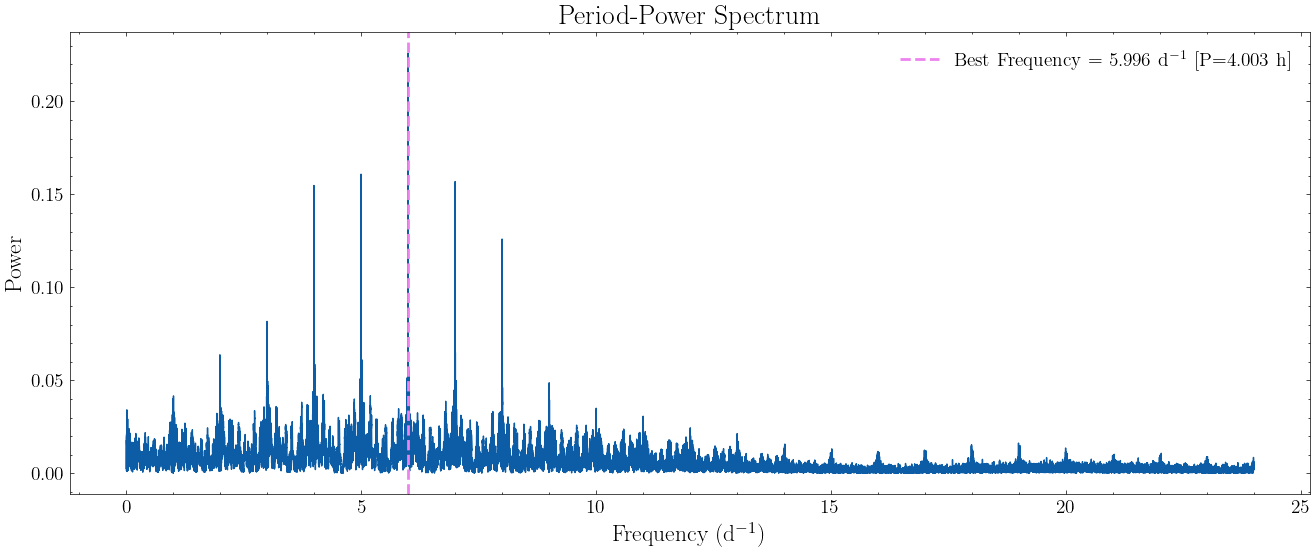

In [66]:
figure, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 6))
ax.plot(freqs, power)
ax.axvline(bestFreq.value, color='violet', linestyle='--', label=f"Best Frequency = {bestFreq.value:0.3f} d$^{{-1}}$ [P={bestPeriod.to(u.hour):0.3f}]", linewidth=2, alpha=1)

ax.set_title("Period-Power Spectrum", fontsize=20)
ax.set_xlabel(r"Frequency ($\mathrm{d}^{-1}$)", fontsize=17)
ax.set_ylabel("Power", fontsize=17)
ax.tick_params(axis='both', labelsize=14)

ax.legend(fontsize=14)
print(f"Periodo: {bestPeriod.to(u.hour)} ({bestPeriod})")
print(f"Frecuencia: {1.0 / bestPeriod}")

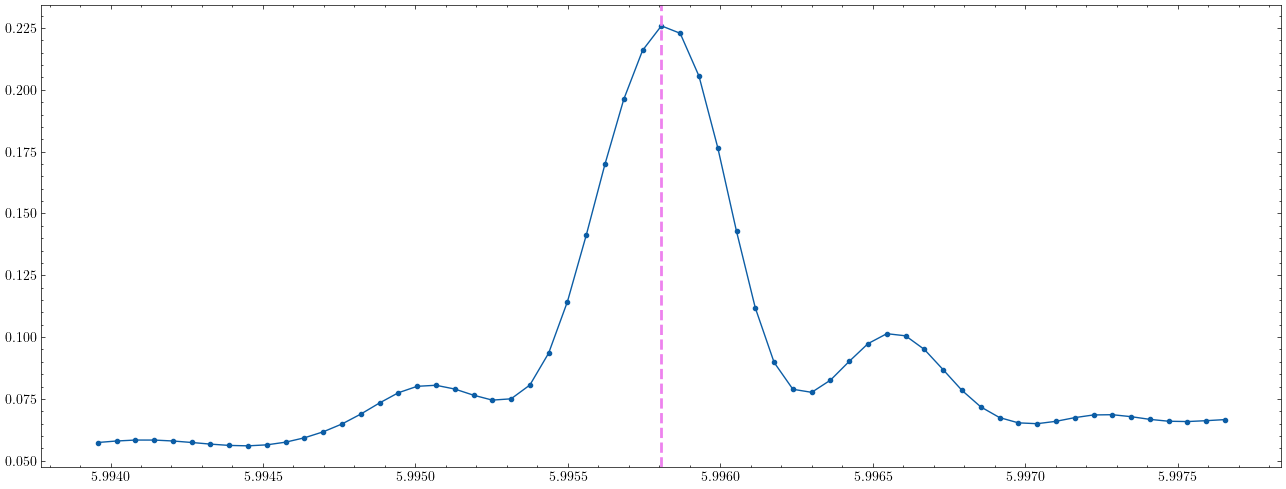

In [19]:
WINDOW_SIZE = 30

peakIdx = np.argmax(power)
freqWindow = freqs[peakIdx-WINDOW_SIZE:peakIdx+WINDOW_SIZE+1]
powerWindow = power[peakIdx-WINDOW_SIZE:peakIdx+WINDOW_SIZE+1]

plt.figure(figsize=(16, 6))
plt.plot(freqWindow, powerWindow, marker='.')
plt.axvline(freqs[peakIdx].value, color='violet', linestyle='--', label=f"Best Frequency = {bestFreq.value:0.3f} day$^{{-1}}$ [P={bestPeriod.to(u.hour):0.3f}]", linewidth=2, alpha=1)

Std: 5.399249022458585e-06 d (0.00012958197653900605 h)


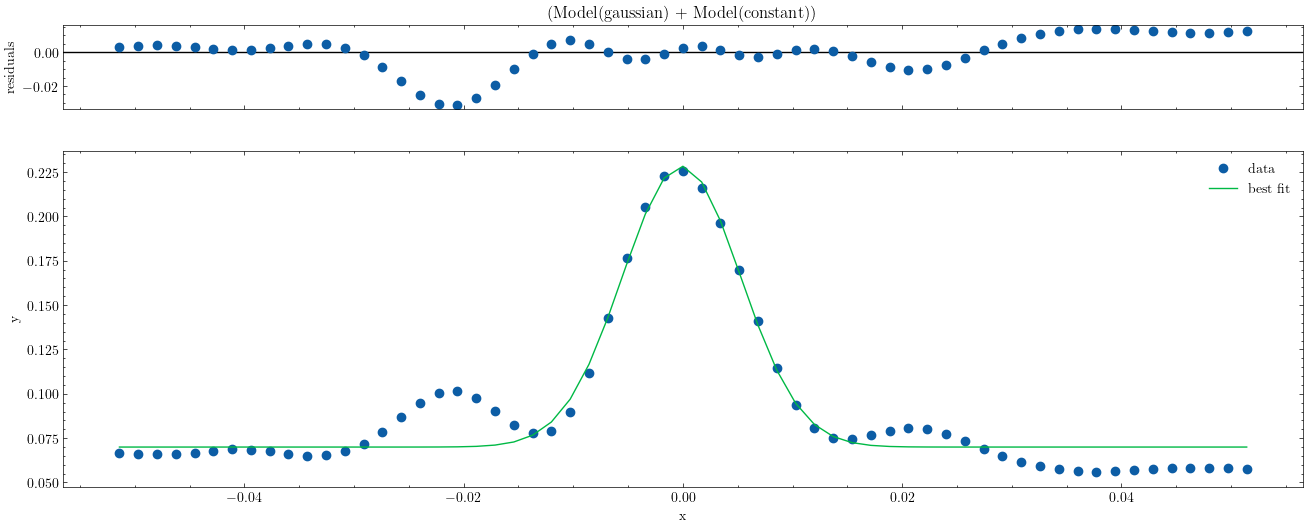

In [61]:
# adjusting Gaussian to determine uncertainties
from lmfit.models import GaussianModel, ConstantModel
from lmfit.model import ModelResult

SCALE_FACTOR = 1000

model = GaussianModel() + ConstantModel()

periodWindow = 1/freqWindow
normalizedPeriodWindow = (periodWindow - np.median(periodWindow)) * SCALE_FACTOR
fitResult: ModelResult = model.fit(powerWindow, x=normalizedPeriodWindow)

fitResult.plot(fig_kws=dict(figsize=(16, 6)))
fitSigma = (fitResult.best_values['sigma']/SCALE_FACTOR) * (u.day)
maxDisplacedPeriod = (1/freqs[peakIdx]) + fitSigma
print(f"Std: {(maxDisplacedPeriod - bestPeriod)} ({(maxDisplacedPeriod - bestPeriod).to(u.hour)})")
fitResult

# Phase Plot

Adopted period: 0.3335660396161509 d (8.005584950787622 h)


/tmp/ipykernel_9747/4156596453.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


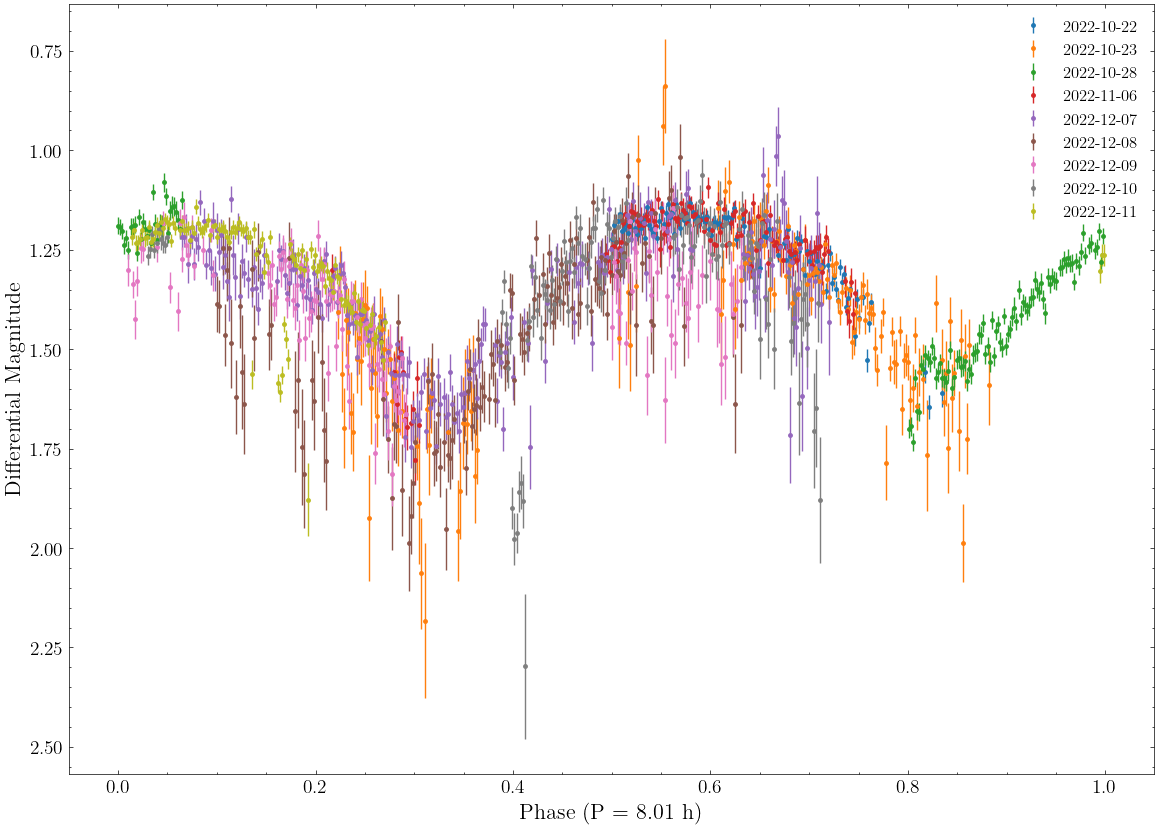

In [25]:
from matplotlib import cm

periodHarmonic = 2
period = bestPeriod*periodHarmonic
print(f"Adopted period: {period} ({period.to(u.hour)})")

tsObsvDates = atoDiffMag['obsv_date'].unique()

cmap = cm.get_cmap('tab10')
dateColors = [cmap(c) for c in np.linspace(0.001, 1, len(tsObsvDates), endpoint=False)]

figure, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 10))
foldedTs = observationsTs.fold(period=period, normalize_phase=True)
for obsvDate, color in zip(tsObsvDates, dateColors):
    obsvPoints = foldedTs[foldedTs['obsv_date'] == obsvDate]
    ax.errorbar(obsvPoints.time.value + 0.5, obsvPoints['iturbide_mag'], obsvPoints['iturbide_err'], fmt='.', color=color, markersize=5, label=obsvDate)
ax.legend(fontsize=12)

ax.set_xlabel(f"Phase (P = {period.value * 24:.2f} h)", fontsize=16)
ax.set_ylabel("Differential Magnitude", fontsize=16)

ax.tick_params(labelsize=14)
ax.invert_yaxis()

Text(0, 0.5, 'Magnitude')

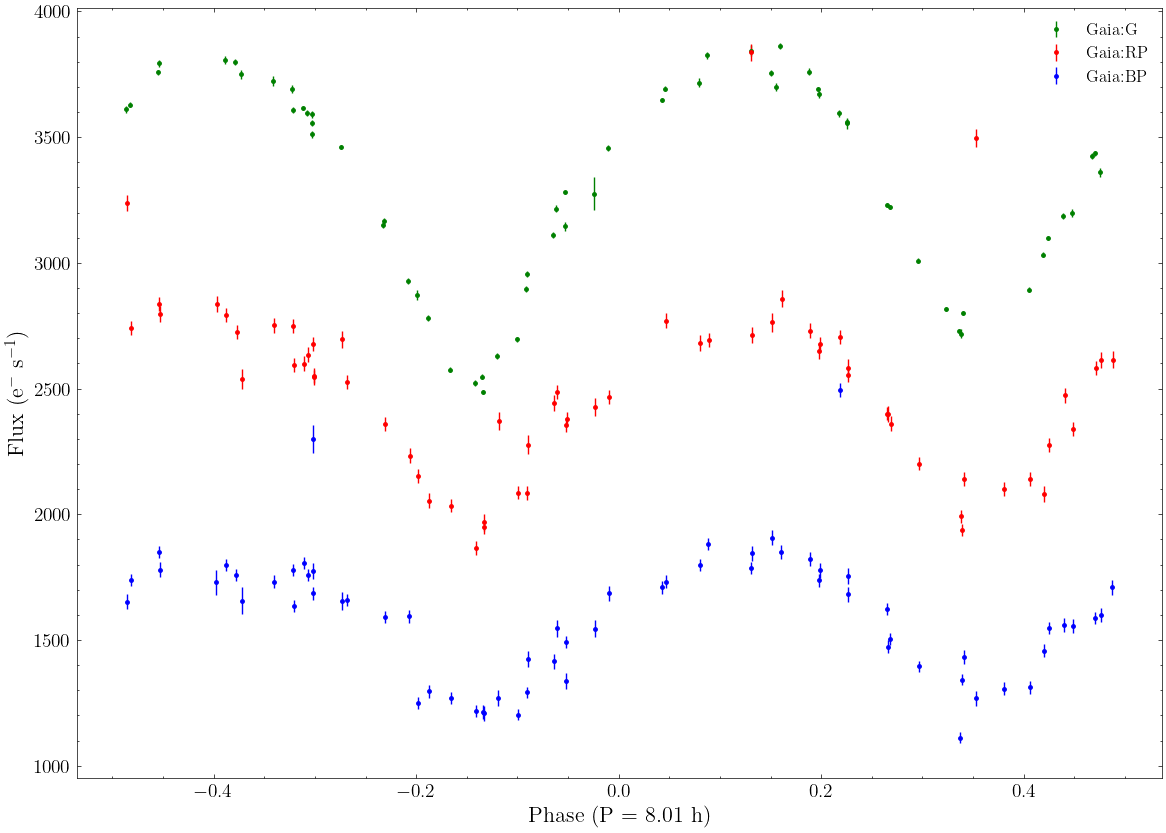

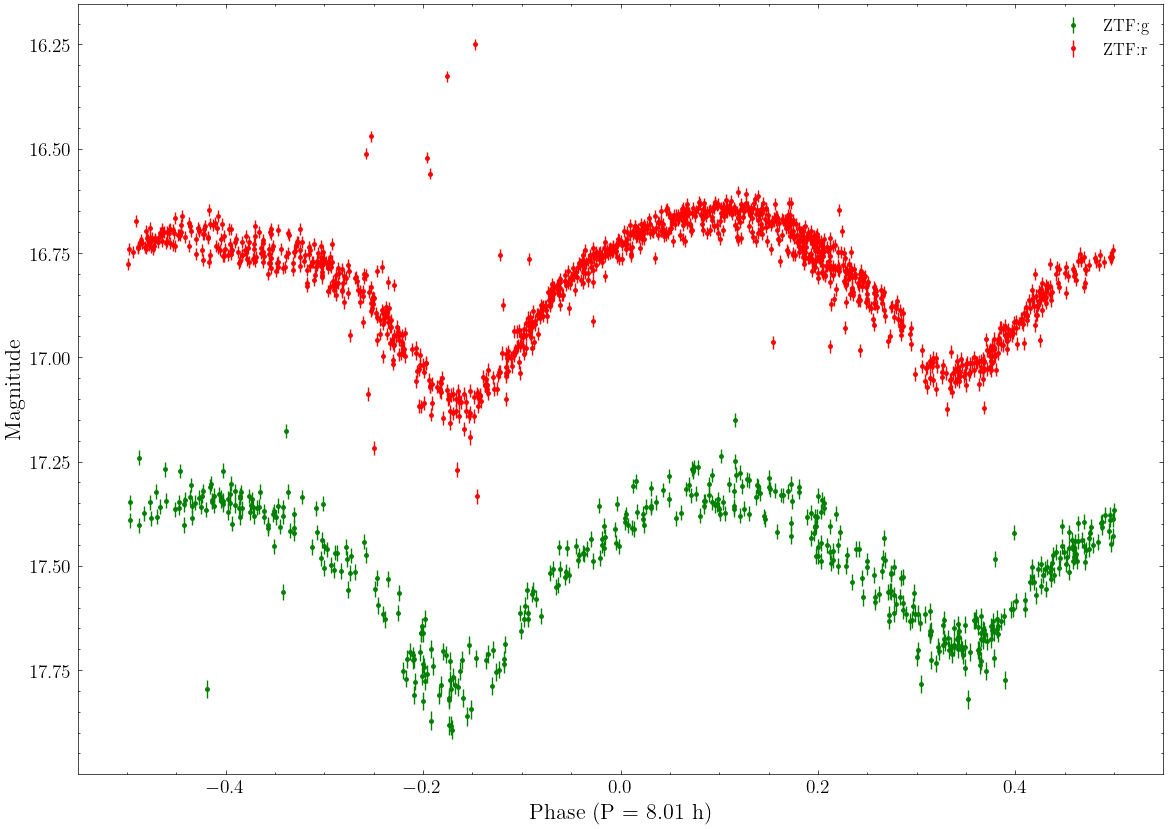

In [23]:
# gaia plot
gaiaColors = {
    "Gaia:G": 'g',
    "Gaia:RP": 'r',
    "Gaia:BP": 'b'
}
plt.figure(figsize=(14, 10))
for band, fluxCol, errCol in zip(gaiaBands, gaiaFluxCols, gaiaErrCols):
    bandData = foldedTs[foldedTs['band'] == band]
    plt.errorbar(bandData.time, bandData[fluxCol], bandData[errCol], marker='.', linestyle='none', c=gaiaColors[band], label=band, markersize=5)
plt.legend(fontsize=12)
plt.gca().tick_params(axis='both', labelsize=14)
plt.ylabel(r"Flux $(\mathrm{e}^{-} \ \mathrm{s}^{-1})$", fontsize=16)
plt.xlabel(f"Phase (P = {period.value * 24:.2f} h)", fontsize=16)

ztfColors = {
    "ZTF:g": 'g',
    "ZTF:r": 'r'
}
plt.figure(figsize=(14, 10))
for band, fluxCol, errCol in zip(ztfBands, ztfMagCols, ztfErrCols):
    bandData = foldedTs[foldedTs['band'] == band]
    plt.errorbar(bandData.time, bandData[fluxCol], bandData[errCol], marker='.', linestyle='none', c=ztfColors[band], label=band, markersize=5)
plt.legend(fontsize=12)
plt.gca().tick_params(axis='both', labelsize=14)
plt.gca().invert_yaxis()
plt.xlabel(f"Phase (P = {period.value * 24:.2f} h)", fontsize=16)
plt.ylabel("Magnitude", fontsize=16)

# Iturbide normalized flux

In [37]:
import math

def findClosestQuarterPhaseIdx(foldedTs: TimeSeries) -> int:
	adjustedPhases = foldedTs.time.value + 0.5 # so that phases go 0 -> 1
	diff = np.abs(adjustedPhases - 0.25)
	return np.argmin(diff)

quarterPhaseIdx = findClosestQuarterPhaseIdx(foldedTs)
quarterPhaseMag = foldedTs['iturbide_mag'][quarterPhaseIdx]

foldedTs['iturbide_norm_flux'] = 10**(-(2/5) * (foldedTs['iturbide_mag'].value - quarterPhaseMag))
foldedTs['iturbide_norm_ferr'] = (foldedTs['iturbide_norm_flux'] * foldedTs['iturbide_err'] * math.log(10)) / 2.5

foldedTs

time,bjd,band,iturbide_mag,iturbide_err,obsv_date,gaia_g_flux,gaia_g_err,gaia_r_flux,gaia_r_err,gaia_b_flux,gaia_b_err,ztf_g_mag,ztf_g_err,ztf_r_mag,ztf_r_err,iturbide_norm_flux,iturbide_norm_ferr
,,,,,,,,,,,,,,,,,
float64,float64,str18,float64,float64,str10,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.0,2459874.6669364087,Iturbide:Luminance,1.2220000000000013,0.0206155281280883,2022-10-22,--,--,--,--,--,--,--,--,--,--,1.1673470764921918,0.02216512296928287
0.0021002135994255215,2459874.6676369687,Iturbide:Luminance,1.189,0.01746424919657298,2022-10-22,--,--,--,--,--,--,--,--,--,--,1.2033722711826853,0.019356445081300543
0.004195211708355248,2459874.668335789,Iturbide:Luminance,1.2317,0.01655294535724685,2022-10-22,--,--,--,--,--,--,--,--,--,--,1.156964411084871,0.017638878203599627
0.006294046050735584,2459874.6690358887,Iturbide:Luminance,1.1771999999999991,0.01746424919657298,2022-10-22,--,--,--,--,--,--,--,--,--,--,1.216522091687572,0.01956796215255701
0.00838871470136789,2459874.669734599,Iturbide:Luminance,1.1602999999999994,0.01655294535724685,2022-10-22,--,--,--,--,--,--,--,--,--,--,1.2356059757244946,0.018837833821532694
0.01048892830075876,2459874.670435159,Iturbide:Luminance,1.2020000000000017,0.01746424919657298,2022-10-22,--,--,--,--,--,--,--,--,--,--,1.1890496789850966,0.019126063780406828
0.012583235384918415,2459874.6711337487,Iturbide:Luminance,1.1966999999999999,0.01655294535724685,2022-10-22,--,--,--,--,--,--,--,--,--,--,1.1948681916079187,0.018216752649603624
0.014689355499852418,2459874.671836279,Iturbide:Luminance,1.1867000000000019,0.01969771560359221,2022-10-22,--,--,--,--,--,--,--,--,--,--,1.2059241708615185,0.021878197717851385


/tmp/ipykernel_9747/2374881828.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


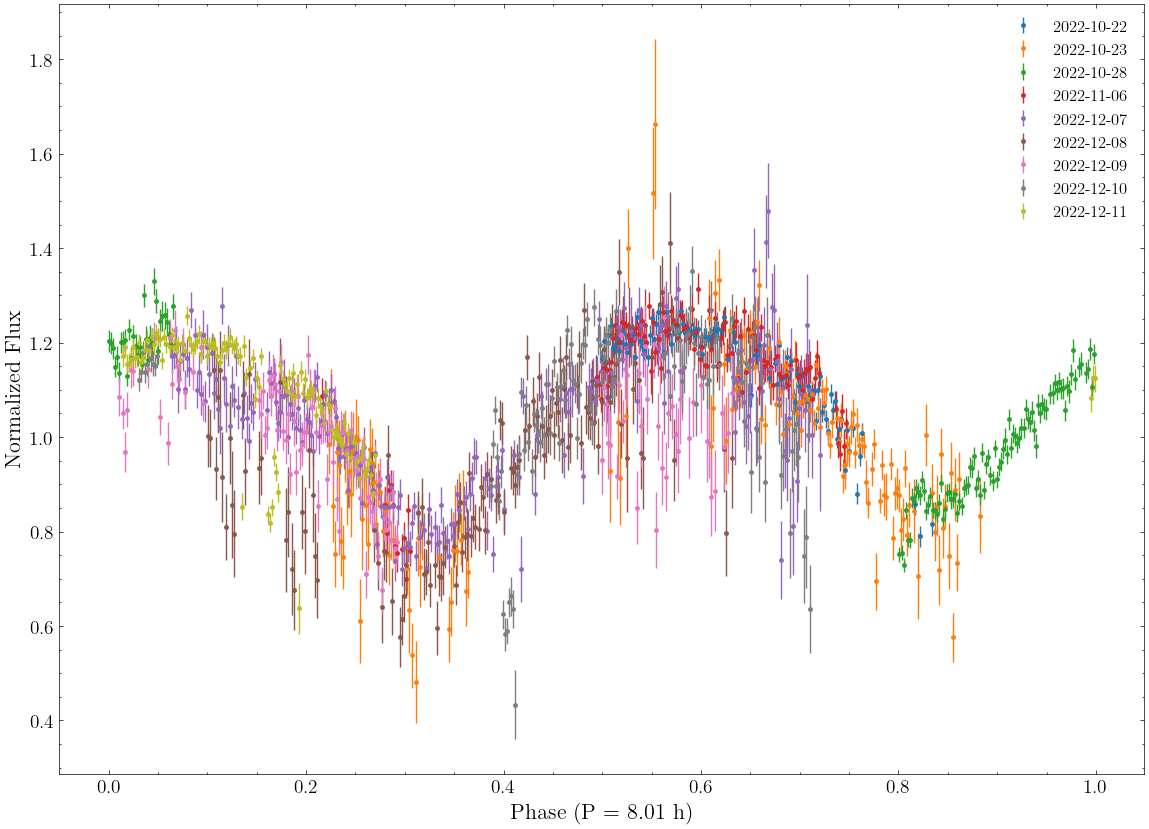

In [38]:
from matplotlib import cm

tsObsvDates = atoDiffMag['obsv_date'].unique()

cmap = cm.get_cmap('tab10')
dateColors = [cmap(c) for c in np.linspace(0.001, 1, len(tsObsvDates), endpoint=False)]

figure, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 10))
for obsvDate, color in zip(tsObsvDates, dateColors):
    obsvPoints = foldedTs[foldedTs['obsv_date'] == obsvDate]
    ax.errorbar(obsvPoints.time.value + 0.5, obsvPoints['iturbide_norm_flux'], obsvPoints['iturbide_norm_ferr'], fmt='.', color=color, markersize=5, label=obsvDate)
ax.legend(fontsize=12)

ax.set_xlabel(f"Phase (P = {period.value * 24:.2f} h)", fontsize=16)
ax.set_ylabel("Normalized Flux", fontsize=16)

ax.tick_params(labelsize=14)

In [ ]:
# TODO: output results to ecsv file to fully replace qphot_timeseries_analysis notebook
ITURBIDE_OUTPUT_PATH